In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time,math,csv
import itertools
import collections

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

### Load State FIPS code map

This is a list of the states that we care about.

In [2]:
state_fips_to_name = {}
state_name_to_fips = {}
with open("data/state_fips.csv", "r") as f:
    for line in f:
        line = line.strip()
        if line != "":
            parts = line.split(",")
            state_fips_to_name["%02d" % (int(parts[2]))] = parts[0]
            state_name_to_fips[parts[0]] = "%02d" % (int(parts[2]))

### Load county level census historical data

In [3]:
historical_population = collections.OrderedDict()
with open("data/historical_population.csv", "r") as f:
    reader = csv.DictReader(f, delimiter=",")
    for row in reader:
        
        fips_code = row["Geo_FIPS"]
        values = np.array([
            float(row["pop_1940"]),
            float(row["pop_1950"]),
            float(row["pop_1960"]),
            float(row["pop_1970"]),
            float(row["pop_1980"]),
            float(row["pop_1990"]),
            float(row["pop_2000"]),
            float(row["pop_2010"])
        ])
        historical_population[fips_code] = values

In [4]:
historical_housing_units = collections.OrderedDict()
with open("data/historical_housing_units.csv", "r") as f:
    reader = csv.DictReader(f, delimiter=",")
    for row in reader:
        
        fips_code = row["Geo_FIPS"]
        values = np.array([
            float(row["hu_1940"]),
            float(row["hu_1950"]),
            float(row["hu_1960"]),
            float(row["hu_1970"]),
            float(row["hu_1980"]),
            float(row["hu_1990"]),
            float(row["hu_2000"]),
            float(row["hu_2010"])
        ])
        historical_housing_units[fips_code] = values

### Load block group level estimated historical data

Note: Broomfield County, Colorado was created in 2001. This is the only county that is in the 2010 census, that is not also in the historical data. https://en.wikipedia.org/wiki/Broomfield,_Colorado

Note: Clifton Forge city, Virginia existed up until 2001, when it reverted back into a town. This is the only county that is in the historical data that is not in the 2010 data. https://en.wikipedia.org/wiki/Clifton_Forge,_Virginia


In [5]:
data_fields = [
    "ACS12_5yr_B25034010", # Housing Units: Built 1939 or Earlier
    "ACS12_5yr_B25034009", # Housing Units: Built 1940 to 1949
    "ACS12_5yr_B25034008", # Housing Units: Built 1950 to 1959
    "ACS12_5yr_B25034007", # Housing Units: Built 1960 to 1969
    "ACS12_5yr_B25034006", # Housing Units: Built 1970 to 1979
    "ACS12_5yr_B25034005", # Housing Units: Built 1980 to 1989
    "ACS12_5yr_B25034004", # Housing Units: Built 1990 to 1999
    "ACS12_5yr_B25034003"  # Housing Units: Built 2000 to 2009
]

In [6]:
acs_housing_unit_estimates_bg = collections.OrderedDict()
acs_housing_unit_estimates_county = collections.OrderedDict()

with open("data/R11628343_SL150.txt", "r", encoding="latin-1") as f:
    reader = csv.DictReader(f, delimiter="\t")

    for row in reader:
        state_code = row["Geo_STATE"]
        county_code = row["Geo_COUNTY"]
        county_fips = state_code + county_code
        fips_code = row["Geo_FIPS"]

        if state_code in state_fips_to_name:
            
            if county_fips not in acs_housing_unit_estimates_bg:
                acs_housing_unit_estimates_bg[county_fips] = collections.OrderedDict()
                acs_housing_unit_estimates_county[county_fips] = np.zeros(len(data_fields))
            
            values = np.array([
                int(row[field_name]) for field_name in data_fields
            ])
            
            acs_housing_unit_estimates_bg[county_fips][fips_code] = values
            acs_housing_unit_estimates_county[county_fips] += values
            
            ''' Find which counties exist in the ACS 5YR data, but not the historical data 
            '''
            if not county_fips in historical_population:
                print(row["Geo_QName"], county_code, fips_code)

In [10]:
acs_housing_unit_estimates_bg["51560"] = {}
acs_housing_unit_estimates_county["51560"] = np.zeros(len(data_fields))

#historical_housing_units["08014"] = np.zeros(len(data_fields))
#historical_population["08014"] = np.zeros(len(data_fields))

### Plot estimated vs. predicted number of housing units without proportional fitting

Here each point is the number of ACS estimated number of housing units per county vs the historical count of number of housing units per county for some time period, t. I've inlcluded all time periods in the plot.

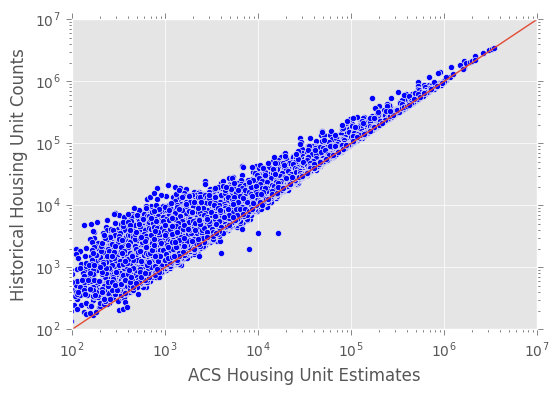

In [13]:
county_list = historical_housing_units.keys()

#xs = [np.sum(np.cumsum(acs_housing_unit_estimates_county[k])) for k in county_list]
#ys = [np.sum(historical_housing_units[k]) for k in county_list]

xs = np.array([np.cumsum(acs_housing_unit_estimates_county[k]).flatten() for k in county_list]).flatten()
ys = np.array([historical_housing_units[k].flatten() for k in county_list]).flatten()

plt.figure()

limits = [1e2, 1e7]

plt.plot(limits, limits)
plt.scatter(xs, ys)

plt.xlim(limits)
plt.ylim(limits)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("ACS Housing Unit Estimates")
plt.ylabel("Historical Housing Unit Counts")

plt.show()
plt.close()

### Hammer method fitting for number of housing units per block group

In [14]:
hammer_housing_unit_estimates_bg = collections.OrderedDict()

for county_fips, block_group_dict in acs_housing_unit_estimates_bg.items():
    
    hammer_housing_unit_estimates_bg[county_fips] = collections.OrderedDict()
    
    for block_group_fips in block_group_dict.keys():
    
        hammer_housing_unit_estimates_bg[county_fips][block_group_fips] = np.zeros(len(data_fields))
    
        cumulative_county = 0.0
        cumulative_block_group = 0.0
        
        for t in range(len(data_fields)):
            cumulative_county += acs_housing_unit_estimates_county[county_fips][t]
            cumulative_block_group += acs_housing_unit_estimates_bg[county_fips][block_group_fips][t]
        
            hammer_housing_unit_estimates_bg[county_fips][block_group_fips][t] = \
                (historical_housing_units[county_fips][t] / cumulative_county) * cumulative_block_group

In [15]:
hammer_housing_unit_estimates_county = collections.OrderedDict()

for county_fips, block_group_dict in acs_housing_unit_estimates_bg.items():
    hammer_housing_unit_estimates_county[county_fips] = np.zeros(len(data_fields))
    
    for block_group_fips in block_group_dict.keys():
        hammer_housing_unit_estimates_county[county_fips] += \
            hammer_housing_unit_estimates_bg[county_fips][block_group_fips]

### Plot estimated vs. predicted number of housing units with proportional fitting

We repeat the same plot as above and show that the "fitted" number of housing units per county matches the number reported by the census over all time steps.

The only place that does not match up now is the "51560" county that was added.

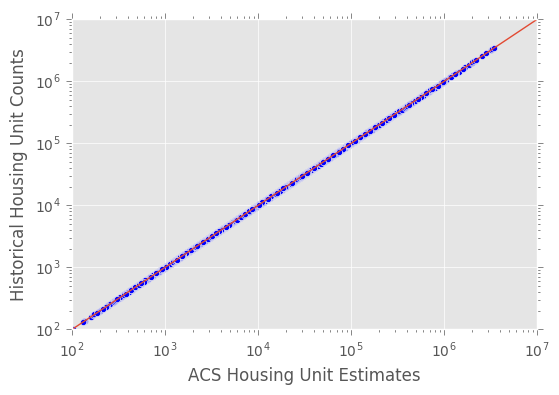

Mismatch 23360 0.0 1732.0
Mismatch 23361 0.0 1738.0
Mismatch 23362 0.0 1807.0
Mismatch 23363 0.0 2011.0
Mismatch 23364 0.0 2064.0
Mismatch 23365 0.0 2131.0
Mismatch 23366 0.0 2069.0


In [16]:
county_list = historical_housing_units.keys()

xs = np.array([hammer_housing_unit_estimates_county[k].flatten() for k in county_list]).flatten()
ys = np.array([historical_housing_units[k].flatten() for k in county_list]).flatten()

plt.figure()

limits = [1e2, 1e7]

plt.plot(limits, limits)
plt.scatter(xs, ys)

plt.xlim(limits)
plt.ylim(limits)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("ACS Housing Unit Estimates")
plt.ylabel("Historical Housing Unit Counts")

plt.show()
plt.close()


for i in range(xs.shape[0]):
    if np.abs(xs[i]-ys[i]) > 1e-6:
        print("Mismatch", i, xs[i], ys[i])

### Save block group "Hammer" estimated number of housing units to file

In [17]:
f = open("data/hammer_historical_housing_units.csv", "w")
f.write("Geo_COUNTY_FIPS,Geo_BG_FIPS,hu_1940,hu_1950,hu_1960,hu_1970,hu_1980,hu_1990,hu_2000,hu_2010\n")
for county_fips, block_group_dict in acs_housing_unit_estimates_bg.items():
    for block_group_fips in block_group_dict.keys():
        f.write("%s,%s,%s\n" % (
            county_fips,
            block_group_fips,
            ",".join(map(str, hammer_housing_unit_estimates_bg[county_fips][block_group_fips]))
        ))
f.close()